# Mobility data


Data downloaded from https://www.mitma.es/ministerio/covid-19/evolucion-movilidad-big-data/opendata-movilidad



    Data downloaded from https://www.mitma.es/ministerio/covid-19/evolucion-movilidad-big-data/opendata-movilidad by year and month of data :
    
*yyyymm_maestra1_mitma_municipio.tar*

    Untar by day : 

*yyyymmdd_maestra_1_mitma_municipio.txt.gz*

    Decompress  :

*yyyymmdd_maestra_1_mitma_municipio.txt*


    After this process, there are one file for each day containing mobility data.



**Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import zipfile
import requests
import io

In [3]:
import geopandas as gpd 

## Provinces identification

Provinces are identified trough the number that identifies its municipalities.


 - Mapa de España por distritos/municipios

In [4]:
local_path ='/tmp/' # donde descomprimir los ficheros zip decargados

In [5]:
z_dist = zipfile.ZipFile("/home/jose/Trabajo_tfm/zonificacion_distritos.zip") # pathname absoluto
z_dist.extractall(path=local_path)

In [6]:
z_munic = zipfile.ZipFile("/home/jose/Trabajo_tfm/zonificacion_municipios.zip") # pathname absoluto
z_munic.extractall(path=local_path)

In [7]:
nombresFicheros_distritos = [y for y in sorted(z_dist.namelist()) for ending in ['dbf','prj','shp','shx'] if y[-3:]== ending and y[1] != "_"]
nombresFicheros_distritos

['zonificacion-distritos/distritos_mitma.dbf',
 'zonificacion-distritos/distritos_mitma.prj',
 'zonificacion-distritos/distritos_mitma.shp',
 'zonificacion-distritos/distritos_mitma.shx']

In [8]:
nombresFicheros_munic = [y for y in sorted(z_munic.namelist()) for ending in ['dbf','prj','shp','shx'] if y[-3:]== ending and y[1] != "_"]
nombresFicheros_munic

['zonificacion-municipios/municipios_mitma.dbf',
 'zonificacion-municipios/municipios_mitma.prj',
 'zonificacion-municipios/municipios_mitma.shp',
 'zonificacion-municipios/municipios_mitma.shx']

In [9]:
dbf, prj, shp, shx = [filename for filename in nombresFicheros_munic]
espana_munic = gpd.read_file(local_path + shp)
print("Shape of the dataframe: {}".format(espana_munic.shape)) 
print("Projection of dataframe: {}".format(espana_munic.crs))

Shape of the dataframe: (2205, 2)
Projection of dataframe: epsg:3042


In [10]:
dbf, prj, shp, shx = [filename for filename in nombresFicheros_distritos]
espana_dist = gpd.read_file(local_path + shp)
print("Shape of the dataframe: {}".format(espana_dist.shape)) 
print("Projection of dataframe: {}".format(espana_dist.crs))

Shape of the dataframe: (2850, 2)
Projection of dataframe: epsg:3042


--  -------

### Municipality-District relationship

In [12]:
distritos_municipios = pd.read_csv(
    '~/Trabajo_tfm/datos_csv/relaciones_distrito_mitma.csv')  # distritos_municipios.info()
distritos_municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10494 entries, 0 to 10493
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   distrito         10494 non-null  int64 
 1   distrito_mitma   10494 non-null  object
 2   municipio_mitma  10494 non-null  object
dtypes: int64(1), object(2)
memory usage: 246.1+ KB


In [13]:
distritos_municipios.head()

,distrito,distrito_mitma,municipio_mitma
0,100101,01001_AM,01001_AM
1,100201,01002,01002
2,100301,01058_AM,01058_AM
3,100401,01010_AM,01010_AM
4,100601,01047_AM,01047_AM


### municipio-municipio_mitma relationship

In [14]:
relaciones_municipio_mitma = pd.read_csv('~/Trabajo_tfm/datos_csv/relaciones_municipio_mitma.csv') #relaciones_municipio_mitma.info()
relaciones_municipio_mitma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8125 entries, 0 to 8124
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   municipio        8125 non-null   int64 
 1   municipio_mitma  8125 non-null   object
dtypes: int64(1), object(1)
memory usage: 127.1+ KB


In [15]:
relaciones_municipio_mitma.head()

,municipio,municipio_mitma
0,1001,01001_AM
1,1002,01002
2,1003,01058_AM
3,1004,01010_AM
4,1006,01047_AM


In [16]:
municipios = pd.merge(relaciones_municipio_mitma, distritos_municipios)
municipios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104170 entries, 0 to 104169
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   municipio        104170 non-null  int64 
 1   municipio_mitma  104170 non-null  object
 2   distrito         104170 non-null  int64 
 3   distrito_mitma   104170 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.0+ MB


In [17]:
municipios.tail()

,municipio,municipio_mitma,distrito,distrito_mitma
104165,52001,52001,5200104,5200104
104166,52001,52001,5200105,5200105
104167,52001,52001,5200106,5200106
104168,52001,52001,5200107,5200107
104169,52001,52001,5200108,5200108


In [18]:
[municipios.municipio_mitma == municipios.distrito_mitma]

[0          True
 1          True
 2          True
 3          True
 4          True
           ...  
 104165    False
 104166    False
 104167    False
 104168    False
 104169    False
 Length: 104170, dtype: bool]

### Selection of provinces with GIS files

Choose municipalities of a province delimited by an interval

In [19]:
def provincia_div (inferior, superior):
    
    provincia = relaciones_municipio_mitma.loc[
      relaciones_municipio_mitma['municipio']>= inferior].loc[
        relaciones_municipio_mitma.loc[relaciones_municipio_mitma['municipio']>= inferior]['municipio']< superior]
    
    provincia['ID']= provincia.municipio_mitma
    provincia_gis = pd.merge(espana_munic, provincia, how='left', on='ID')
    provincia_gis = provincia_gis.dropna()
    
    return provincia, provincia_gis

In [20]:
alicante_div, alicante_gis = provincia_div(3000,  4000)
almeria_div, almeria_gis = provincia_div(4000,  5000)
badajoz_div, badajoz_gis = provincia_div(6000,  7000)
cadiz_div, cadiz_gis = provincia_div(11000, 12000)
ciudad_real_div, ciudad_real_gis = provincia_div(13000, 14000)
cordoba_div, cordoba_gis = provincia_div(14000, 15000)
coruna_div, coruna_gis = provincia_div(15000, 16000)
granada_div, granada_gis = provincia_div(18000, 19000)
huelva_div, huelva_gis = provincia_div(21000, 22000)
jaen_div, jaen_gis = provincia_div(23000, 24000)
lugo_div, lugo_gis = provincia_div(27000, 28000)
madrid_div, madrid_gis = provincia_div(28000, 29000)
malaga_div, malaga_gis = provincia_div(29000, 30000)
orense_div, orense_gis = provincia_div(32000, 33000)
palencia_div, palencia_gis = provincia_div(34000, 35000)
pontevedra_div, pontevedra_gis = provincia_div(36000, 37000)
salamanca_div, salamanca_gis = provincia_div(37000, 38000)
sevilla_div, sevilla_gis = provincia_div(41000, 42000)
valencia_div, valencia_gis = provincia_div(46000, 47000)
zamora_div, zamora_gis = provincia_div(49000, 50000)
zaragoza_div, zaragoza_gis = provincia_div(50000, 60000)

In [21]:
galicia_gis = pd.concat([coruna_gis.geometry, lugo_gis.geometry, orense_gis.geometry,
                         pontevedra_gis.geometry]) 
andalucia_gis = pd.concat([jaen_gis.geometry, cordoba_gis.geometry, sevilla_gis.geometry,
                           huelva_gis.geometry, cadiz_gis.geometry, malaga_gis.geometry,
                           granada_gis.geometry, almeria_gis.geometry]) 

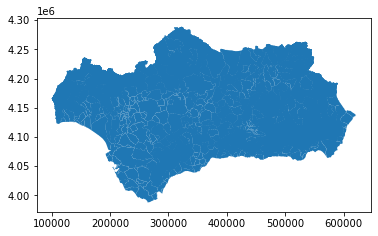

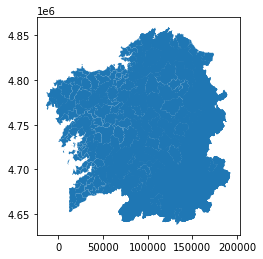

In [22]:
ax1 = andalucia_gis.plot()
ax2 = galicia_gis.plot()
plt.show()

In [23]:
provincias = pd.concat([coruna_gis.geometry, lugo_gis.geometry, orense_gis.geometry,
                        pontevedra_gis.geometry, jaen_gis.geometry, cordoba_gis.geometry,
                        sevilla_gis.geometry,
                        huelva_gis.geometry, cadiz_gis.geometry, malaga_gis.geometry,
                        granada_gis.geometry, almeria_gis.geometry,
                        badajoz_gis.geometry, zamora_gis.geometry,
                        zaragoza_gis.geometry,
                        valencia_gis.geometry,
                        salamanca_gis.geometry,
                        palencia_gis.geometry,
                        madrid_gis.geometry,
                        ciudad_real_gis.geometry,
                        alicante_gis.geometry
                        ])

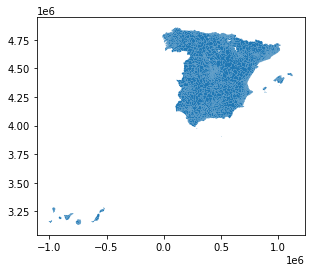

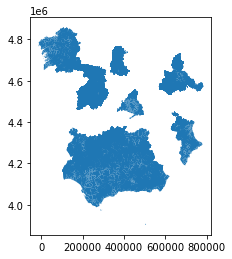

In [24]:
espana_dist_gis = espana_dist.geometry
ax = espana_dist_gis.plot()
ax = provincias.plot()

plt.show()

In [25]:
divs_provincias = [[alicante_div, 'ALICANTE'], [almeria_div, 'ALMERIA'],
                   [badajoz_div, 'BADAJOZ'], [cadiz_div, 'CADIZ'],
                   [ciudad_real_div, 'CIUDAD_REAL'], [cordoba_div, 'CORDOBA'],
                   [granada_div, 'GRANADA'], [huelva_div, 'HUELVA'],
                   [jaen_div, 'JAEN'], [coruna_div, 'LA_CORUÑA'],
                   [lugo_div, 'LUGO'], [madrid_div, 'MADRID'],
                   [malaga_div, 'MALAGA'], [orense_div, 'ORENSE'],
                   [palencia_div, 'PALENCIA'], [pontevedra_div, 'PONTEVEDRA'],
                   [salamanca_div, 'SALAMANCA'], [sevilla_div, 'SEVILLA'],
                   [valencia_div, 'VALENCIA'], [zamora_div, 'ZAMORA'],
                   [zaragoza_div, 'ZARAGOZA']]

In [51]:
#datos_fechas = pd.read_csv("~/Trabajo_tfm/datos_csv/jaen_meteo.csv", usecols=['fecha']) # cualquier
#datos_fechas = pd.read_csv("~/Trabajo_tfm/datos_csv/jaen_meteo.csv") # cualquier

# Data

In [26]:
from ipynb.fs.full.funciones_eda import  funcion_inversion_fecha, funcion_fecha

In [27]:
datos_fechas = pd.read_csv("~/Trabajo_tfm/datos_csv/datos_fechas.csv", usecols=['fecha'])
#datos_fechas

,fecha
0,2020-03-01
1,2020-03-02
2,2020-03-03
3,2020-03-04
4,2020-03-05
...,...
332,2021-01-27
333,2021-01-28
334,2021-01-29
335,2021-01-30


In [28]:
# para leer los ficheros por fecha
fechas =[]
for dia in np.arange(datos_fechas.size) :
    fecha = funcion_inversion_fecha (datos_fechas.fecha[dia])
    fechas.append(fecha)

## Extraction of distance and period mobility data
**"destino" field used to separate external from internal trips**

In [59]:
distancias = []
distancias_ext = []
cols_eliminar = ["origen", 'destino']

for fecha in fechas :
    
    fecha_d = funcion_fecha(fecha)
    print('Dia :', fecha_d)
    
    dia = pd.read_csv('~/Trabajo_tfm/datos_csv/m1_municipios/'+ fecha +'_maestra_1_mitma_municipio.txt',
                      sep = '|', thousands = '.', memory_map  = True, low_memory=False,
                      usecols=["origen", "destino","periodo", "distancia", "viajes", "viajes_km"])
    
    viajes_int = dia[dia.origen == dia.destino]
    viajes_ext = dia[dia.origen != dia.destino]
    
    viajes_int['municipio_mitma']= viajes_int.origen # para unirlos con merge
    viajes_ext['municipio_mitma']= viajes_ext.origen # para unirlos con merge
    
    #dia = dia.drop(columns = cols_eliminar)

    for div_provincia in divs_provincias :# loop por provincias 
                  
        total_viajes_provincia = pd.merge(div_provincia[0], # municipios provincias
                                          viajes_int.drop(columns = cols_eliminar), how='left', on='municipio_mitma') 
        total_viajes_ext = pd.merge(div_provincia[0], # municipios provincias
                                      viajes_ext.drop(columns = cols_eliminar), how='left', on='municipio_mitma') 
        
        distancias.append(
                [fecha_d, div_provincia[1],
                 total_viajes_provincia[total_viajes_provincia.distancia == '0005-002'].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '002-005'].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '005-010'].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '010-050'].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '050-100'].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '100+'].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([0,1,2,3])].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([4,5,6,7])].viajes.sum(),                         
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([8,9,10,11])].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([12,13,14,15])].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([16,17,18,19])].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([20,21,22,23])].viajes.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '0005-002'].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '002-005'].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '005-010'].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '010-050'].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '050-100'].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.distancia == '100+'].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([0,1,2,3])].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([4,5,6,7])].viajes_km.sum(),                         
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([8,9,10,11])].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([12,13,14,15])].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([16,17,18,19])].viajes_km.sum(),
                 total_viajes_provincia[total_viajes_provincia.periodo.isin([20,21,22,23])].viajes_km.sum(),
                 
                 total_viajes_ext[total_viajes_ext.distancia == '0005-002'].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '002-005'].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '005-010'].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '010-050'].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '050-100'].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '100+'].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([0,1,2,3])].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([4,5,6,7])].viajes.sum(),                         
                 total_viajes_ext[total_viajes_ext.periodo.isin([8,9,10,11])].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([12,13,14,15])].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([16,17,18,19])].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([20,21,22,23])].viajes.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '0005-002'].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '002-005'].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '005-010'].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '010-050'].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '050-100'].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.distancia == '100+'].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([0,1,2,3])].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([4,5,6,7])].viajes_km.sum(),                         
                 total_viajes_ext[total_viajes_ext.periodo.isin([8,9,10,11])].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([12,13,14,15])].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([16,17,18,19])].viajes_km.sum(),
                 total_viajes_ext[total_viajes_ext.periodo.isin([20,21,22,23])].viajes_km.sum()
                ])  


Dia : 2020-03-01
Dia : 2020-03-02
Dia : 2020-03-03
Dia : 2020-03-04
Dia : 2020-03-05
Dia : 2020-03-06
Dia : 2020-03-07
Dia : 2020-03-08
Dia : 2020-03-09
Dia : 2020-03-10
Dia : 2020-03-11
Dia : 2020-03-12
Dia : 2020-03-13
Dia : 2020-03-14
Dia : 2020-03-15
Dia : 2020-03-16
Dia : 2020-03-17
Dia : 2020-03-18
Dia : 2020-03-19
Dia : 2020-03-20
Dia : 2020-03-21
Dia : 2020-03-22
Dia : 2020-03-23
Dia : 2020-03-24
Dia : 2020-03-25
Dia : 2020-03-26
Dia : 2020-03-27
Dia : 2020-03-28
Dia : 2020-03-29
Dia : 2020-03-30
Dia : 2020-03-31
Dia : 2020-04-01
Dia : 2020-04-02
Dia : 2020-04-03
Dia : 2020-04-04
Dia : 2020-04-05
Dia : 2020-04-06
Dia : 2020-04-07
Dia : 2020-04-08
Dia : 2020-04-09
Dia : 2020-04-10
Dia : 2020-04-11
Dia : 2020-04-12
Dia : 2020-04-13
Dia : 2020-04-14
Dia : 2020-04-15
Dia : 2020-04-16
Dia : 2020-04-17
Dia : 2020-04-18
Dia : 2020-04-19
Dia : 2020-04-20
Dia : 2020-04-21
Dia : 2020-04-22
Dia : 2020-04-23
Dia : 2020-04-24
Dia : 2020-04-25
Dia : 2020-04-26
Dia : 2020-04-27
Dia : 2020-04-

In [61]:
m1_distancias = pd.DataFrame(
    distancias,columns= ['fecha', 'provincia', 'v_muy_cortos','v_cortos',
                         'v_medios','v_largos','v_muy_largos','v_extra_largos',
                         'v_noche','v_madrugada','v_mañana', 'v_mediodia', 'v_sobremesa', 'v_tarde',
                         'v_km_muy_cortos','v_km_cortos', 'v_km_medios','v_km_largos','v_km_muy_largos',
                         'v_km_extra_largos','v_km_noche','v_km_madrugada','v_km_mañana','v_km_mediodia',
                         'v_km_sobremesa','v_km_tarde',
                         'vext_muy_cortos','vext_cortos',
                         'vext_medios','vext_largos','vext_muy_largos','vext_extra_largos',
                         'vext_noche','vext_madrugada','vext_mañana', 'vext_mediodia', 'vext_sobremesa', 'vext_tarde',
                         'vext_km_muy_cortos','vext_km_cortos', 'vext_km_medios','vext_km_largos','vext_km_muy_largos',
                         'vext_km_extra_largos','vext_km_noche','vext_km_madrugada','vext_km_mañana','vext_km_mediodia',
                         'vext_km_sobremesa','vext_km_tarde'])

In [62]:
m1_distancias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7077 entries, 0 to 7076
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fecha                 7077 non-null   object 
 1   provincia             7077 non-null   object 
 2   v_muy_cortos          7077 non-null   float64
 3   v_cortos              7077 non-null   float64
 4   v_medios              7077 non-null   float64
 5   v_largos              7077 non-null   float64
 6   v_muy_largos          7077 non-null   float64
 7   v_extra_largos        7077 non-null   float64
 8   v_noche               7077 non-null   float64
 9   v_madrugada           7077 non-null   float64
 10  v_mañana              7077 non-null   float64
 11  v_mediodia            7077 non-null   float64
 12  v_sobremesa           7077 non-null   float64
 13  v_tarde               7077 non-null   float64
 14  v_km_muy_cortos       7077 non-null   float64
 15  v_km_cortos          

In [63]:
m1_distancias.head()

,fecha,provincia,v_muy_cortos,v_cortos,v_medios,v_largos,v_muy_largos,v_extra_largos,v_noche,v_madrugada,...,vext_km_medios,vext_km_largos,vext_km_muy_largos,vext_km_extra_largos,vext_km_noche,vext_km_madrugada,vext_km_mañana,vext_km_mediodia,vext_km_sobremesa,vext_km_tarde
0,2020-03-01,ALICANTE,1.322250e+09,804633464.0,222461316.0,39322732.0,0.0,0.0,264283976.0,177396270.0,...,5.721850e+09,2.154784e+10,8.518258e+09,1.820639e+10,2.588726e+09,3.923355e+09,1.252925e+10,1.565224e+10,1.667656e+10,4.635016e+09
1,2020-03-01,ALMERIA,4.137365e+08,307464963.0,197629520.0,65431700.0,0.0,0.0,100438393.0,76635719.0,...,1.669589e+09,1.440393e+10,4.621445e+09,1.267408e+10,1.615540e+09,2.223428e+09,6.993912e+09,8.703933e+09,1.152187e+10,2.948829e+09
2,2020-03-01,BADAJOZ,5.620126e+08,292754287.0,228679981.0,132586257.0,0.0,0.0,134096187.0,84005893.0,...,1.707081e+09,1.556644e+10,7.969185e+09,2.418670e+10,1.912023e+09,3.451396e+09,9.512004e+09,1.368057e+10,1.689393e+10,4.314848e+09
3,2020-03-01,CADIZ,1.139626e+09,762263188.0,170314872.0,37096003.0,35172.0,0.0,243768978.0,155137510.0,...,2.357122e+09,8.493790e+09,9.246472e+09,2.039986e+10,1.544056e+09,2.501498e+09,7.486108e+09,1.151443e+10,1.393903e+10,3.779070e+09
4,2020-03-01,CIUDAD_REAL,4.181868e+08,131185519.0,92363723.0,71743512.0,460920.0,0.0,83422745.0,53835197.0,...,9.633742e+08,8.667398e+09,4.441580e+09,2.080106e+10,1.241544e+09,1.845293e+09,5.946952e+09,9.717944e+09,1.376540e+10,2.629732e+09


In [65]:
from ipynb.fs.full.funciones_eda import descripcionDatosDataset, calidad_datos, graficos_datos

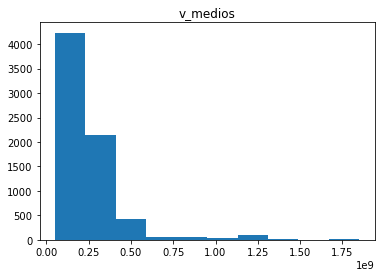

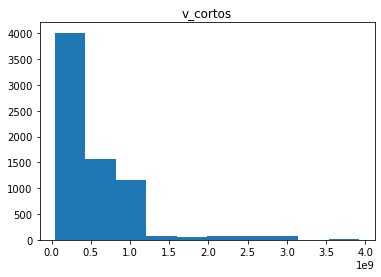

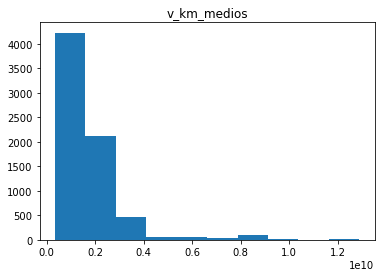

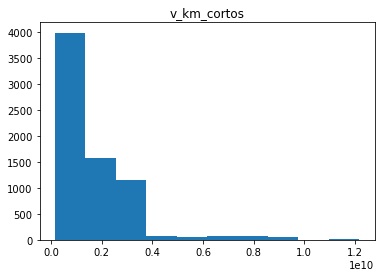

In [71]:
graficos_datos(m1_distancias[['v_medios','v_cortos','v_km_medios','v_km_cortos']])

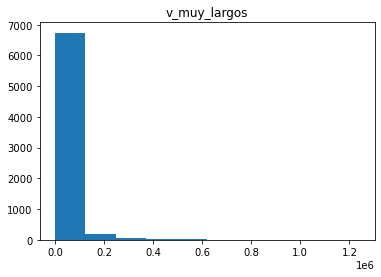

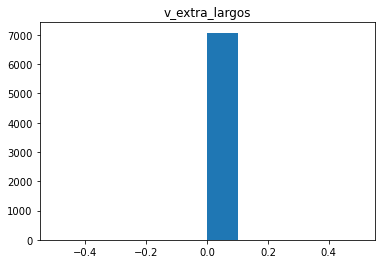

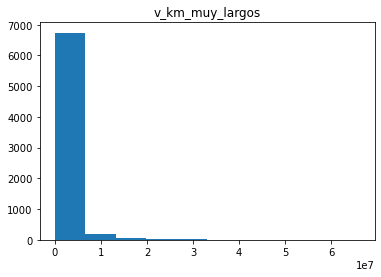

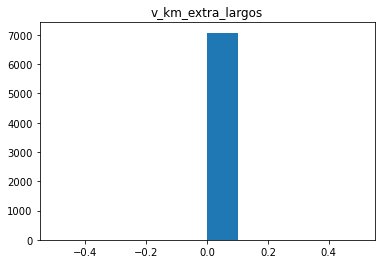

In [70]:
graficos_datos(m1_distancias[['v_muy_largos','v_extra_largos','v_km_muy_largos','v_km_extra_largos']])

In [69]:
descripcionDatosDataset(m1_distancias[['v_muy_largos','v_extra_largos','v_km_muy_largos','v_km_extra_largos']])

Cantidad de filas: 7077
Cantidad de columnas: 4
----------------------------------------------------------------------------------------------------
Columna: v_muy_largos
Tipo de datos: numérico
Descripción de valores:
min       0.000000e+00
max       1.240320e+06
mean      1.607950e+04
std       7.338077e+04
median    0.000000e+00
Name: v_muy_largos, dtype: float64
----------------------------------------------------------------------------------------------------
Columna: v_extra_largos
Tipo de datos: numérico
Descripción de valores:
min       0.0
max       0.0
mean      0.0
std       0.0
median    0.0
Name: v_extra_largos, dtype: float64
----------------------------------------------------------------------------------------------------
Columna: v_km_muy_largos
Tipo de datos: numérico
Descripción de valores:
min       0.000000e+00
max       6.611160e+07
mean      8.783862e+05
std       4.022425e+06
median    0.000000e+00
Name: v_km_muy_largos, dtype: float64
------------------------

In [67]:
calidad_datos(m1_distancias)

Cantidad de filas: 7077
Cantidad de filas completas: 7077
Cantidad de filas  incompletas: 0
Porcentaje de filas incompletas: 0.0 %
Cantidad de nulos en las columnas  : 
fecha                   0
provincia               0
v_muy_cortos            0
v_cortos                0
v_medios                0
v_largos                0
v_muy_largos            0
v_extra_largos          0
v_noche                 0
v_madrugada             0
v_mañana                0
v_mediodia              0
v_sobremesa             0
v_tarde                 0
v_km_muy_cortos         0
v_km_cortos             0
v_km_medios             0
v_km_largos             0
v_km_muy_largos         0
v_km_extra_largos       0
v_km_noche              0
v_km_madrugada          0
v_km_mañana             0
v_km_mediodia           0
v_km_sobremesa          0
v_km_tarde              0
vext_muy_cortos         0
vext_cortos             0
vext_medios             0
vext_largos             0
vext_muy_largos         0
vext_extra_largos       0

## Save m1 data


In [64]:
#m1_distancias.to_csv("~/Trabajo_tfm/datos_csv/m1_distancias_extend.csv")m1_distancias_extend
m1_distancias.to_csv("~/Trabajo_tfm/datos_csv/m1_extendida.csv")

## Extraction of people mobility data

In [31]:
datos_m2 = []
cols_eliminar = ['distrito']

for fecha in fechas : 
    
    dia = pd.read_csv('~/Trabajo_tfm/m2_municipios/'+ fecha +'_maestra_2_mitma_municipio.txt',
                  sep = '|', thousands = '.', memory_map  = True, low_memory=False,
                  usecols=["distrito", "numero_viajes", "personas"])
   
    dia['municipio_mitma'] = dia.distrito
    dia = dia.drop(columns = cols_eliminar)
    fecha_d = funcion_fecha(fecha)
    #print('Dia :', fecha_d)

    for div_provincia in divs_provincias :# loop por provincias

        total_personas_provincia = pd.merge(div_provincia[0],
                                            dia.drop(columns = cols_eliminar), how='left', on='municipio_mitma')
 
        datos_m2.append([fecha_d, div_provincia[1],
                         total_personas_provincia[total_personas_provincia['numero_viajes'] == '0'].personas.sum(),
                         total_personas_provincia[total_personas_provincia['numero_viajes'] == '1'].personas.sum(),
                         total_personas_provincia[total_personas_provincia['numero_viajes'] == '2'].personas.sum(),
                         total_personas_provincia[total_personas_provincia['numero_viajes'] == '2+'].personas.sum()])

In [32]:
m2_personas = pd.DataFrame(datos_m2, columns= ['fecha','provincia',
                                               'cero_viajes','un_viaje','dos_viajes','mas_de_dos_viajes'])

## Save m2  data

In [33]:
m2_personas
m2_personas.to_csv("~/Trabajo_tfm/datos_csv/m2_personas.csv")

In [38]:
datos_mitma = pd.concat([m1_distancias,m2_personas], axis=1)

In [39]:
datos_mitma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7077 entries, 0 to 7076
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fecha              7077 non-null   object 
 1   provincia          7077 non-null   object 
 2   v_muy_cortos       7077 non-null   float64
 3   v_cortos           7077 non-null   float64
 4   v_medios           7077 non-null   float64
 5   v_largos           7077 non-null   float64
 6   v_muy_largos       7077 non-null   float64
 7   v_extra_largos     7077 non-null   float64
 8   v_noche            7077 non-null   float64
 9   v_madrugada        7077 non-null   float64
 10  v_mañana           7077 non-null   float64
 11  v_mediodia         7077 non-null   float64
 12  v_sobremesa        7077 non-null   float64
 13  v_tarde            7077 non-null   float64
 14  v_km_muy_cortos    7077 non-null   float64
 15  v_km_cortos        7077 non-null   float64
 16  v_km_medios        7077 

In [40]:
cols_eliminar = ['fecha_', "provincia_"]
datos_mitma = datos_mitma.drop(columns = cols_eliminar)
datos_mitma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7077 entries, 0 to 7076
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fecha              7077 non-null   object 
 1   provincia          7077 non-null   object 
 2   v_muy_cortos       7077 non-null   float64
 3   v_cortos           7077 non-null   float64
 4   v_medios           7077 non-null   float64
 5   v_largos           7077 non-null   float64
 6   v_muy_largos       7077 non-null   float64
 7   v_extra_largos     7077 non-null   float64
 8   v_noche            7077 non-null   float64
 9   v_madrugada        7077 non-null   float64
 10  v_mañana           7077 non-null   float64
 11  v_mediodia         7077 non-null   float64
 12  v_sobremesa        7077 non-null   float64
 13  v_tarde            7077 non-null   float64
 14  v_km_muy_cortos    7077 non-null   float64
 15  v_km_cortos        7077 non-null   float64
 16  v_km_medios        7077 

In [42]:
calidad_datos(datos_mitma)

Cantidad de filas: 7077
Cantidad de filas completas: 7077
Cantidad de filas  incompletas: 0
Porcentaje de filas incompletas: 0.0 %
Cantidad de nulos en las columnas  : 
fecha                0
provincia            0
v_muy_cortos         0
v_cortos             0
v_medios             0
v_largos             0
v_muy_largos         0
v_extra_largos       0
v_noche              0
v_madrugada          0
v_mañana             0
v_mediodia           0
v_sobremesa          0
v_tarde              0
v_km_muy_cortos      0
v_km_cortos          0
v_km_medios          0
v_km_largos          0
v_km_muy_largos      0
v_km_extra_largos    0
v_km_noche           0
v_km_madrugada       0
v_km_mañana          0
v_km_mediodia        0
v_km_sobremesa       0
v_km_tarde           0
cero_viajes          0
un_viaje             0
dos_viajes           0
mas_de_dos_viajes    0
dtype: int64
 — — — — - — — — — - — — — — - — — — — - — — — — -


In [43]:
descripcionDatosDataset(datos_mitma)

Cantidad de filas: 7077
Cantidad de columnas: 30
----------------------------------------------------------------------------------------------------
Columna: fecha
Tipo de datos: nominal
Descripción de valores:
-- Valores presentes (10 primeros): ['2020-03-01' '2020-03-02' '2020-03-03' '2020-03-04' '2020-03-05'
 '2020-03-06' '2020-03-07' '2020-03-08' '2020-03-09' '2020-03-10'
 '2020-03-11' '2020-03-12' '2020-03-13' '2020-03-14' '2020-03-15'
 '2020-03-16' '2020-03-17' '2020-03-18' '2020-03-19' '2020-03-20']
-- Cantidad de nulos: 0 = 0.00%
----------------------------------------------------------------------------------------------------
Columna: provincia
Tipo de datos: nominal
Descripción de valores:
-- Valores presentes (10 primeros): ['ALICANTE' 'ALMERIA' 'BADAJOZ' 'CADIZ' 'CIUDAD_REAL' 'CORDOBA' 'GRANADA'
 'HUELVA' 'JAEN' 'LA_CORUÑA' 'LUGO' 'MADRID' 'MALAGA' 'ORENSE' 'PALENCIA'
 'PONTEVEDRA' 'SALAMANCA' 'SEVILLA' 'VALENCIA' 'ZAMORA']
-- Cantidad de nulos: 0 = 0.00%
---------------

Columna: un_viaje
Tipo de datos: numérico
Descripción de valores:
min       1.537888e+07
max       4.982212e+10
mean      9.820675e+07
std       5.956137e+08
median    6.801811e+07
Name: un_viaje, dtype: float64
----------------------------------------------------------------------------------------------------
Columna: dos_viajes
Tipo de datos: numérico
Descripción de valores:
min       5.897811e+07
max       1.577555e+11
mean      3.364074e+08
std       1.885345e+09
median    2.441362e+08
Name: dos_viajes, dtype: float64
----------------------------------------------------------------------------------------------------
Columna: mas_de_dos_viajes
Tipo de datos: numérico
Descripción de valores:
min       7.799470e+07
max       2.895853e+11
mean      5.791763e+08
std       3.465265e+09
median    4.127282e+08
Name: mas_de_dos_viajes, dtype: float64
----------------------------------------------------------------------------------------------------


## Save all 

In [44]:
datos_mitma.to_csv("~/Trabajo_tfm/datos_csv/datos_mitma_ext.csv")

In [45]:
from pandas_profiling import ProfileReport
profile_movilidad = ProfileReport(datos_mitma)

In [46]:
profile_movilidad.to_file("informe_movilidad.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]